In [3]:
from functools import partial
from datetime import datetime, timedelta
import boto3
import json
import copy
import pickle
import io
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.types import *
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2.5})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


"""
Utility function definitions
"""


def date_list(endDate, delta=14):
    
    temp = [endDate]
    for i in range(1, delta + 1):
        temp.append(endDate - timedelta(days=i))
    return '{' + ','.join([str(d.date()) for d in temp]) + '}'


def readParquet(prefix, dates="{*}", hour="{*}", fields=None):
    path = prefix + "/dt=" + dates + "/hr=" + hour + "/"
    return spark.read.parquet(path)

def readCSV(prefix, dates="{*}", hour="{*}", fields=None):
    path = prefix + "/dt=" + dates + "/hr=" + hour + "/"
    return spark.read.csv(path)

def readSeq(prefix, date, hour="*", fields=None, toPandas=False):
    path = prefix + "/dt=" + date + "/hr=" + hour + "/"
    temp = sc.sequenceFile(path).values() \
        .map(bytearray.decode).map(json.loads)
    if isinstance(fields, list):
        temp = temp.flatMap(lambda x: Row([x[field] for field in fields]))
    temp = spark.createDataFrame(temp)
    if isinstance(fields, list):
        for idx, field in enumerate(fields):
            temp = temp.withColumnRenamed("_" + str(idx + 1), field)
    _schema = copy.deepcopy(temp.schema)
    if toPandas:
        return temp.toPandas(), _schema
    return temp, _schema


def round_datetime(timestamp, interval=0):
    tm = datetime.fromtimestamp(timestamp)
    if interval > 0:
        tm = tm - timedelta(minutes=tm.minute % interval, seconds=tm.second)
    return tm


curried_roundDatetime = partial(round_datetime, interval=0)
udf_roundDate = F.udf(curried_roundDatetime, TimestampType())

curried_roundDatetime_20 = partial(round_datetime, interval=20)
udf_roundDate_20 = F.udf(curried_roundDatetime_20, TimestampType())


@F.pandas_udf("int", F.PandasUDFType.GROUPED_AGG)
def median_udf(v):
    return v.median()


@F.pandas_udf("int", F.PandasUDFType.GROUPED_AGG)
def iqr_udf(v):
    iqr = v.quantile(0.75) - v.quantile(0.25)
    return iqr

def gaussian_smooth(df, index, groups, columns, window=5, std=2):
    
    return df.set_index('time_of_day').groupby(groups)[columns] \
                      .rolling(window, win_type='gaussian', min_periods=1, std=std) \
                      .mean().reset_index()

def df_to_s3(df, path, filename):
    s3 = boto3.resource('s3')
    file_type = filename.split(".")[-1]
    with io.StringIO() as outputBuffer:
        if file_type == "pickle":
            pickle.dump(df, outputBuffer)
        elif file_type == "json":
            df.to_json(outputBuffer, orient='index')
        elif file_type == "csv":
            df.to_csv(outputBuffer)
            #json.dump(df, buffer)
        print(outputBuffer.closed)
        outputBuffer.seek(0)
        obj = s3.Object('mist-data-science-dev', f'{path}/{filename}')
        obj.put(Body=outputBuffer.getvalue())
    print(outputBuffer.closed)
    
def get_model(path):
    s3 = boto3.resource('s3')
    content_object = s3.Object('mist-data-science-dev', path)
    file_content = content_object.get()['Body'].read().decode('utf-8')
    json_content = json.loads(file_content)
    return pd.DataFrame.from_dict(json_content, orient='index')
    

"""
Modeling functions
"""
def filter_commands(data_df, agg=None):
    if agg == '20min':
        filter_commands = ['scan-anomaly']

    else:
        filter_commands = ['capacity-anomaly',
                           'rrm-radar', 'acs-request-ap',
                           'rrm-global', 'marvis-action-check']

    return data_df.filter(F.col("command").isin(filter_commands))

def compose_features(data_df):
    feature_df = data_df.groupBy("date", "band", "command-reason") \
        .agg(F.sum("rrm_local_cmd_count").alias("rrm_local_cmd_count"))

    feature_df = feature_df.withColumn("time_of_day", F.date_format(F.col("date"), "HH:mm"))

    return feature_df

def summarize_features(feature_df):
    summary_df = feature_df.groupBy('time_of_day', 'band', 'command-reason') \
                        .agg(median_udf('rrm_local_cmd_count').alias('median_count'),
                             iqr_udf('rrm_local_cmd_count').alias('iqr_count'))
    
    
    return summary_df

"""
Time-series decomp functions
"""

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def plot_SSA(df, var, max_rank=12, n_plot=7, zoom_level=1):
    F_orig = df[var].values
    N = F_orig.shape[0]
    t = np.arange(N)
    L = 200 # The window length.
    K = N - L + 1
    X = np.column_stack([F_orig[i:i+L] for i in range(0,K)])
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.imshow(X)
    ax.set_xlabel("$L$-Lagged Vectors")
    ax.set_ylabel("$K$-Lagged Vectors")
    ax.set_title("The Trajectory Matrix for "+var);

    d = np.linalg.matrix_rank(X) 
    print(f'Rank of trajectory matrix, d = {d}')
    U, Sigma, V = np.linalg.svd(X)
    V = V.T 

    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

    if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")

    n = min(max_rank, d)
    ncols=3
    nrows = n//ncols
    if n%ncols>0: nrows+=1
    fig, ax = plt.subplots(nrows, ncols, figsize=(15,5))
    ax = ax.flatten()
    for i in range(n):
        title = "$\mathbf{X}_{" + str(i) + "}$"
        ax[i].matshow(X_elem[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(title)
    #plt.tight_layout()

    sigma_sumsq = (Sigma**2).sum()
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
    ax[0].set_xlim(0,n)
    ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[0].set_xlabel("$i$")
    ax[0].set_ylabel("Contribution (%)")
    ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
    ax[1].set_xlim(0,n)
    ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[1].set_xlabel("$i$")
    ax[1].set_ylabel("Contribution (%)");
    
    fig, ax= plt.subplots(figsize=(15,8))
    color_cycle = cycler(color=plt.get_cmap('tab20').colors)
    ax.set_prop_cycle(color_cycle)
    F_recon = np.zeros(df.index.shape)
    for i in range(n_plot):
        F_i = X_to_TS(X_elem[i])
        ax.plot(df.index, F_i, lw=2)
        F_recon += F_i 
    ax.set_xlabel("$t$")
    ax.set_ylabel(r"$\tilde{F}_i(t)$")
    legend = [r"$\tilde{F}_{%s}$" %i for i in range(n_plot)]
    ax.set_title(f"The First {n_plot} Components of the Time Series")
    ax.legend(legend, loc=(1.05,0.1))
    ax.xaxis.zoom(zoom_level) 
    ax.tick_params(axis='x', labelrotation = 45)



    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(df.index, F_orig, alpha=0.5, lw=2, c='k')
    ax.plot(df.index, F_recon, alpha=1, lw=4,c='r')
    ax.set_xlabel("$t$")
    ax.set_ylabel(r"$\tilde{F}_i(t)$")
    legend = ["$F_{original}$","$F_{recon}$ {"+str(n_plot)+"}"]
    ax.legend(legend, loc=(1.05,0.1))
    ax.xaxis.zoom(zoom_level) 
    ax.tick_params(axis='x', labelrotation = 45)

    res=np.array(np.subtract(F_orig, F_recon),dtype='float')
    fig, ax= plt.subplots(figsize=(10,6))
    sns.distplot(res, ax=ax)
    ax.set_xlabel("$t$")
    ax.set_ylabel(r"${Residual}$")

### Variable definition

In [104]:
"""
Variables
"""
prefix = "s3://mist-aggregated-stats-production/aggregated-stats/rrm_local_cmd_count/"

#END_DATE = datetime.today()
END_DATE = datetime.strptime('2021-03-07', '%Y-%m-%d')

LAG = 28
smoothing = True
WINDOW_SMOOTH = 5
STD_SMOOTH = 2
CLIP_UPPER = 20000
CLIP_LOWER = 0

upper_scale = 2.5
lower_scale = 1.5

### Data processing

In [ ]:
"""
Processing
"""
dates = date_list(END_DATE, delta=LAG)
data_df = readParquet(prefix, dates)


data_df = data_df.withColumn("command-reason", F.concat(F.col("command").cast(StringType()),
                                                        F.lit("_"),
                                                        F.col("reason").cast(StringType()))).drop('reason')

# Filter and summarize for commands at 10min resolution
data_df = data_df.withColumn("date", udf_roundDate(F.col("timestamp")))
filtered_df = filter_commands(data_df)
feature_df = compose_features(filtered_df)
df_summary_10min = summarize_features(feature_df)

# Filter and summarize for commands at 20min resolution
data_df = data_df.drop("date").withColumn("date", udf_roundDate_20(F.col("timestamp")))
filtered_df = filter_commands(data_df, agg='20min')
feature_df = compose_features(filtered_df)
df_summary_20min = summarize_features(feature_df)
df_anomaly_summary_pandas = pd.concat([df_summary_10min.toPandas(), df_summary_20min.toPandas()])
df_anomaly_summary_pandas = df_anomaly_summary_pandas.sort_values('time_of_day')

### Model 

In [ ]:
model_all = df_anomaly_summary_pandas.copy()
#smoothing=False
if smoothing :
    model_count = model_all.groupby(['band','command-reason'])['time_of_day'].count()
    cmds_smooth = model_count[(model_count==72) | (model_count>=130)].reset_index()['command-reason']
    idx_smooth = model_all['command-reason'].isin(cmds_smooth) 
    
    model_smooth = gaussian_smooth(model_all[idx_smooth],
                                index='time_of_day',
                                groups=['band','command-reason'],
                                columns=['median_count','iqr_count'])
    
    model_all = pd.concat([model_smooth, model_all[~idx_smooth]], sort=False)
    

model_all['upper_limit'] = model_all['median_count'] + upper_scale*model_all['iqr_count']
model_all['lower_limit'] = model_all['median_count'] - lower_scale*model_all['iqr_count']

model_all['upper_limit'] = model_all['upper_limit'].apply(lambda x: np.ceil(min(CLIP_UPPER, x)))
model_all['lower_limit'] = model_all['lower_limit'].apply(lambda x: np.ceil(max(CLIP_LOWER, x)))

model_all.reset_index(drop=True, inplace=True)

#df_to_s3(model_all, "spark_jobs/ruchit-dev/models", "rrm_local_anomaly_model_v2.json")

# Inspect model

* 'acs-request-ap <> acs-request-ap'
* 'acs-request-ap <> rrmL-acs'
- 'capacity-anomaly <> non-wifi'
- 'capacity-anomaly <> wifi-cochannel'
- 'marvis-action-check <> disable-radio'
- 'marvis-action-check <> reset-radio'
- 'rrm-global <> rrmG-ondemand'
- 'rrm-global <> rrmG-scheduled',
- 'rrm-radar <> post-radar', 'scan-anomaly <> non-wifi'
- 'scan-anomaly <> wifi-cochannel'
- 'scan-anomaly <> wifi-cochannel-external'
- 'rrm-radar <> radar-detected'

In [153]:
model_path = "spark_jobs/ruchit-dev/rrm_local_anomaly_model_v2.json"
model_all = get_model(model_path)
model_all.sort_values(by=['command-reason','time_of_day'],inplace=True)

test_date = '2021-03-08'
hour = '{*}'
#test_file = f"s3://mist-data-science-dev/spark_jobs/ruchit-dev/rrm_local_anomaly_testing/dt={test_date}/hr={hour}"
test_file = f"s3://mist-aggregated-stats-staging/aggregated-stats/rrm_local_anomaly_candidates_debug/dt={test_date}/hr={hour}"

df_test = spark.read.parquet(test_file).toPandas()

In [154]:
df_test.head()

,timestamp,time_of_day,band,command-reason,rrm_local_cmd_count,anomaly
0,NaN,13:20,24,capacity-anomaly_non-wifi,334,true
1,NaN,13:40,5,scan-anomaly_wifi-cochannel,72,true
2,NaN,13:00,5,scan-anomaly_wifi-cochannel,87,true
3,NaN,14:20,24,capacity-anomaly_non-wifi,400,true
4,NaN,14:20,5,scan-anomaly_wifi-cochannel,74,true


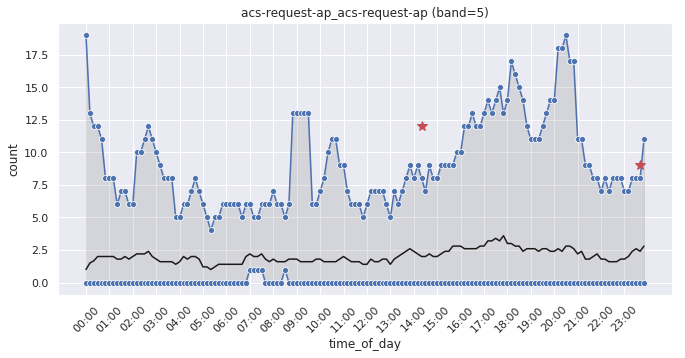

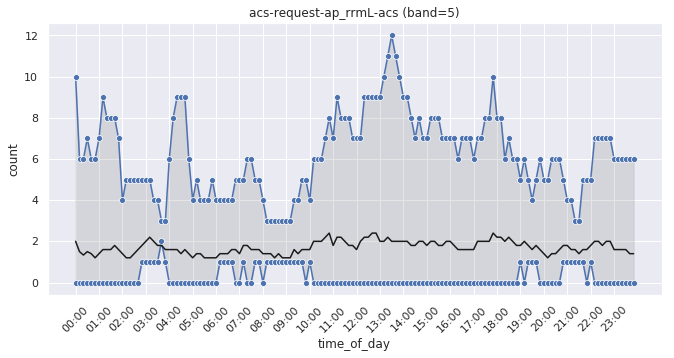

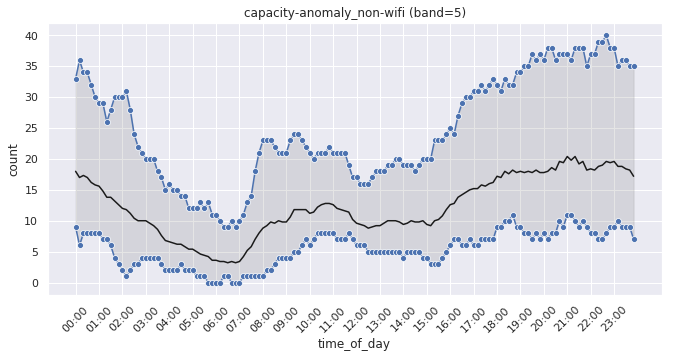

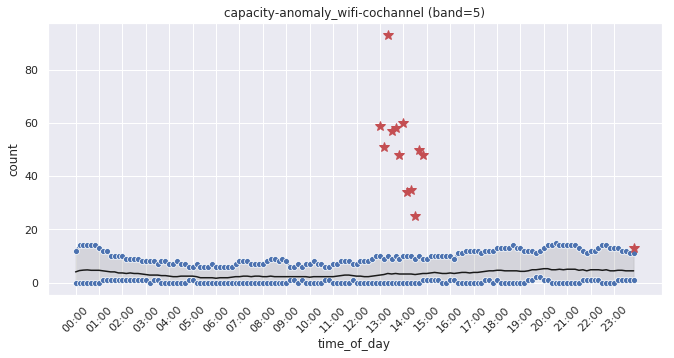

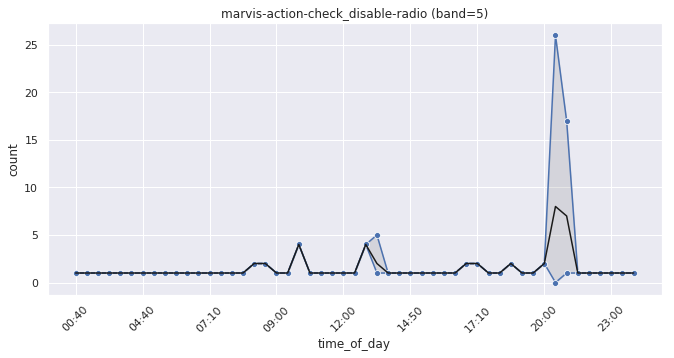

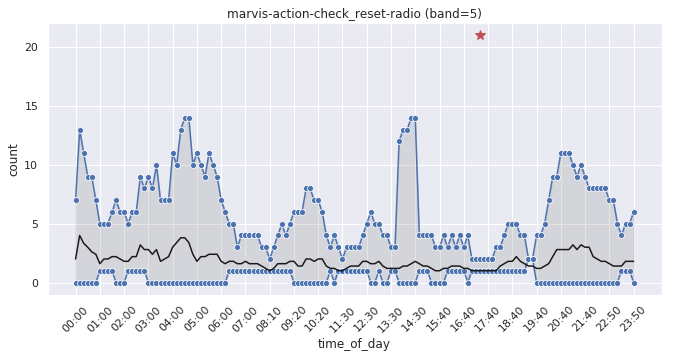

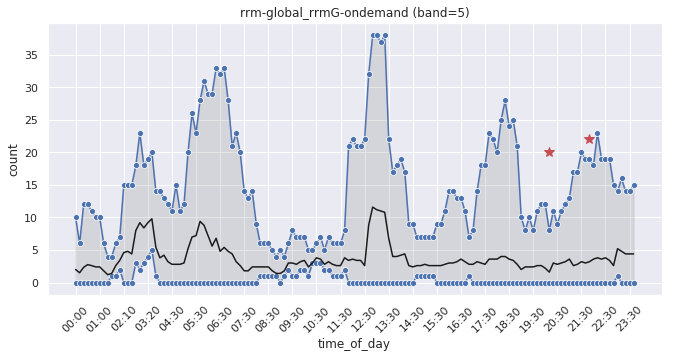

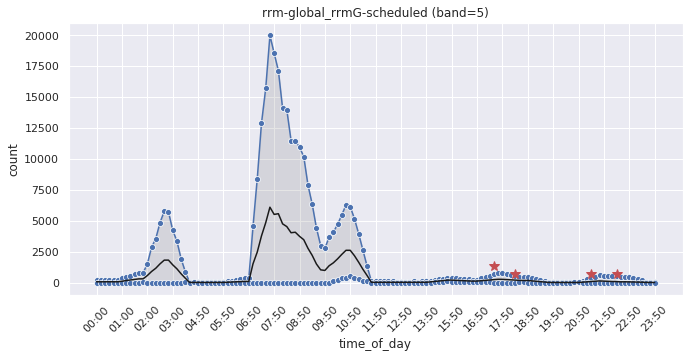

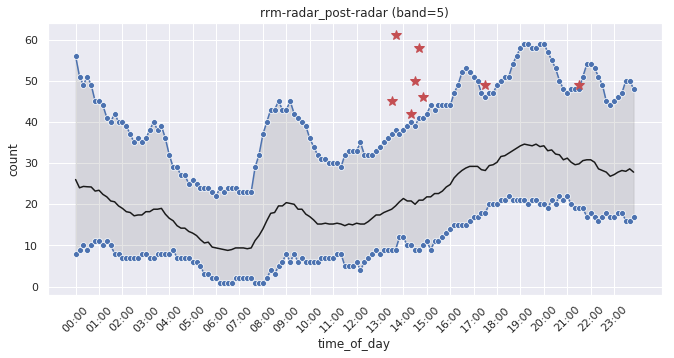

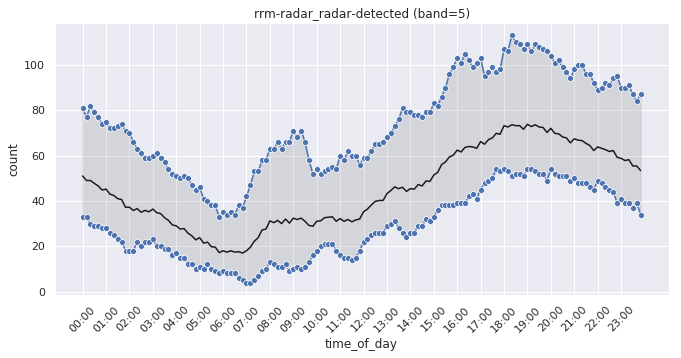

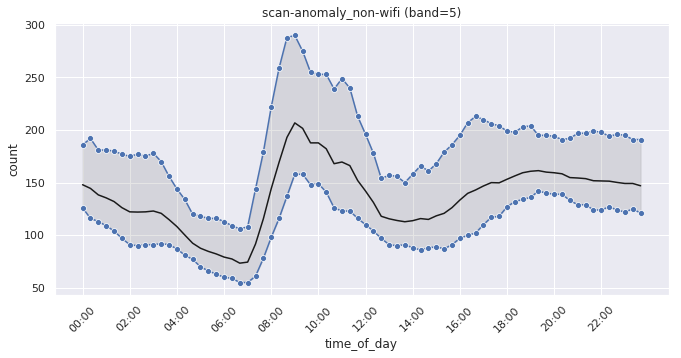

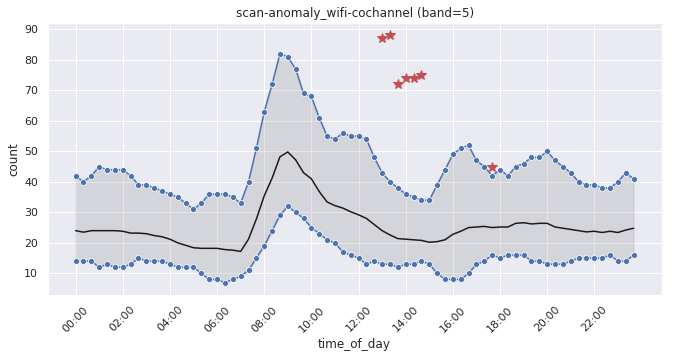

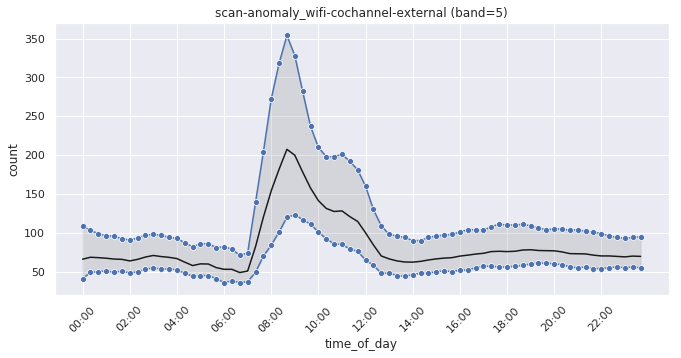

In [155]:
#cmd = 'scan-anomaly <> wifi-cochannel'
band='5'
idx_band = (model_all.band==band)
sns.set(rc={'figure.figsize':(11,5)})

for cmd in np.sort(model_all['command-reason'].unique()):
    idx = idx_band & (model_all['command-reason']==cmd)
    if sum(idx)>0:
        x_labels = model_all.loc[idx,'time_of_day'].values[::6]
        fig, ax = plt.subplots()
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='upper_limit', marker="o", color='b', ax=ax)
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='lower_limit', marker="o", color='b', ax=ax)
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='median_count', color='k', ax=ax)
        #_ = sns.lineplot(data=model_all[idx], x='time_of_day', y='iqr_count', color='g', ax=ax)
        ax.fill_between(model_all.loc[idx,'time_of_day'],
                        model_all.loc[idx,'lower_limit'],
                        model_all.loc[idx,'upper_limit'],
                        alpha=0.2,
                        color='gray')
        
        test_idx = (df_test['band']==band)&(df_test['command-reason']==cmd)
        if sum(test_idx)>0:
            ax.plot(df_test.loc[test_idx,'time_of_day'], df_test.loc[test_idx,'rrm_local_cmd_count'], 'r*', ms=10)


        _ = ax.set_ylabel('count')
        _ = ax.set(xticks=x_labels,
                   title = f"{cmd} (band={band})")
        _ = ax.set_xticklabels(x_labels, rotation=45)

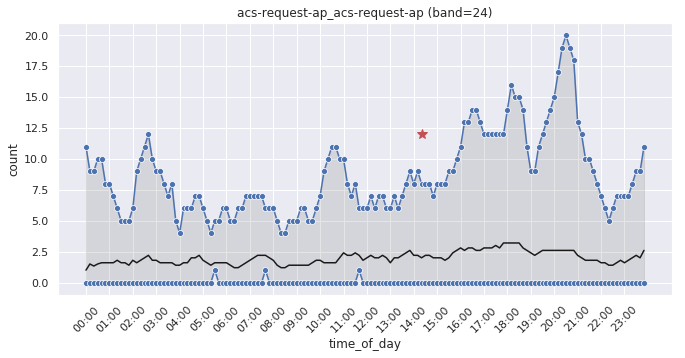

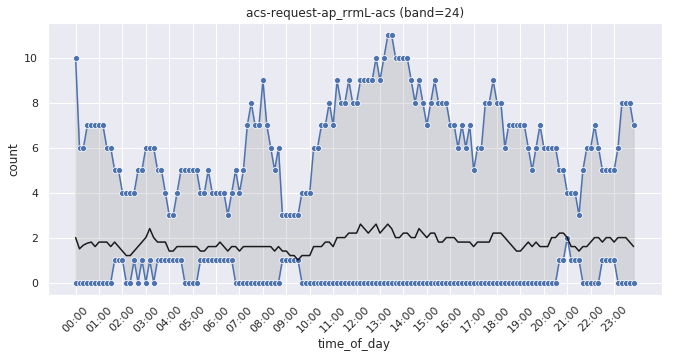

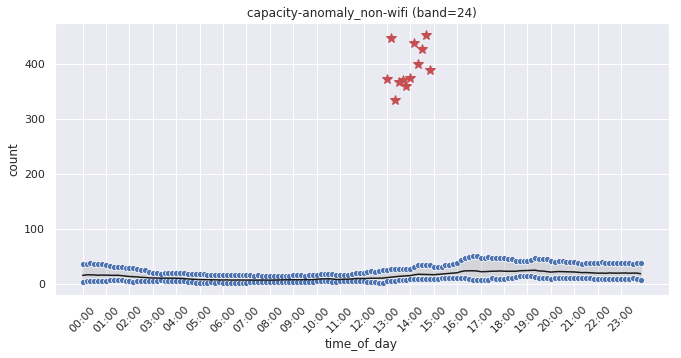

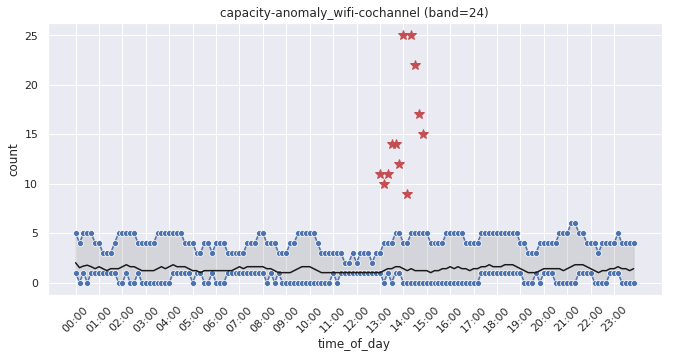

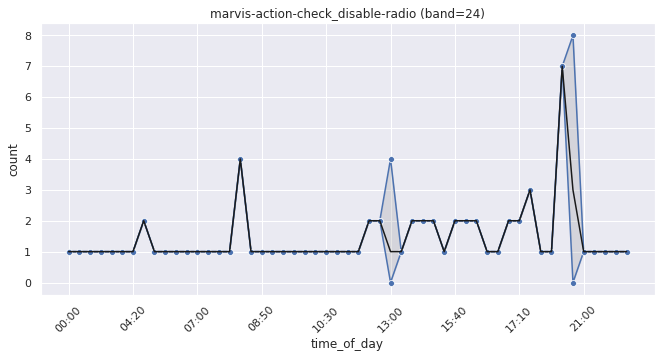

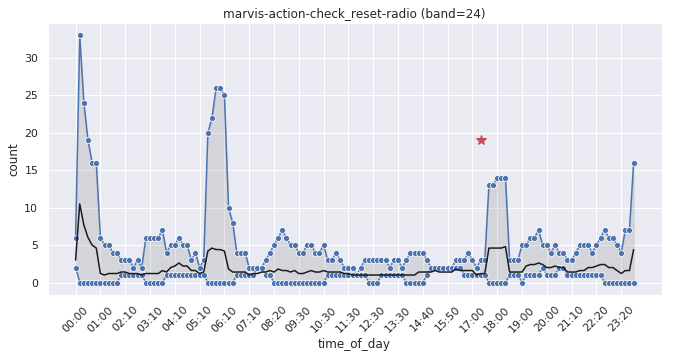

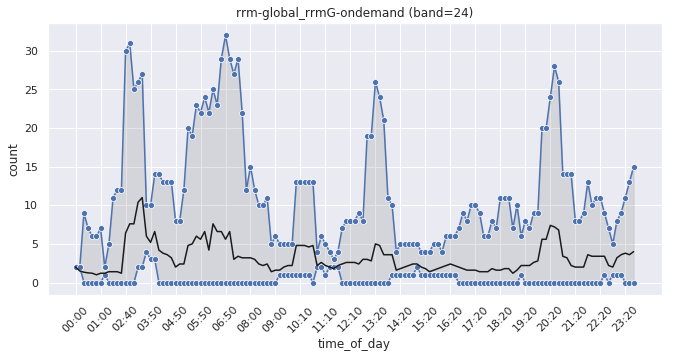

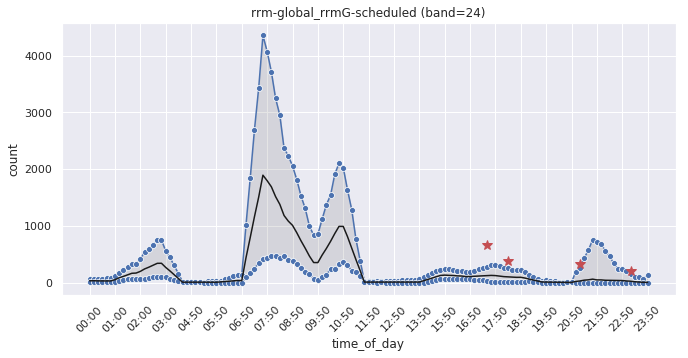

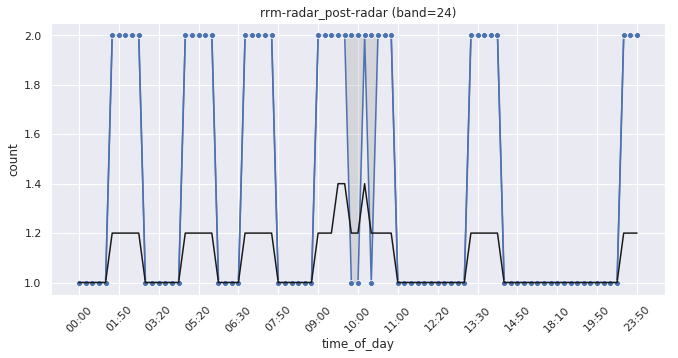

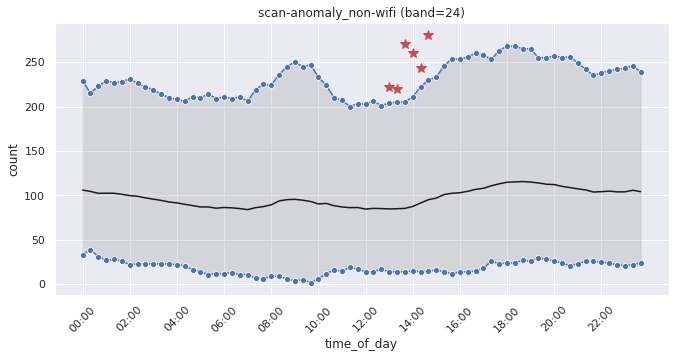

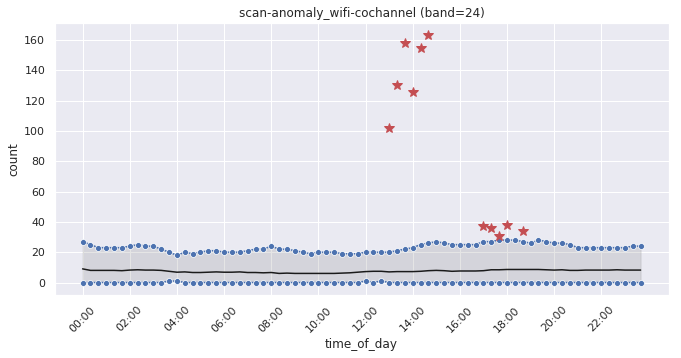

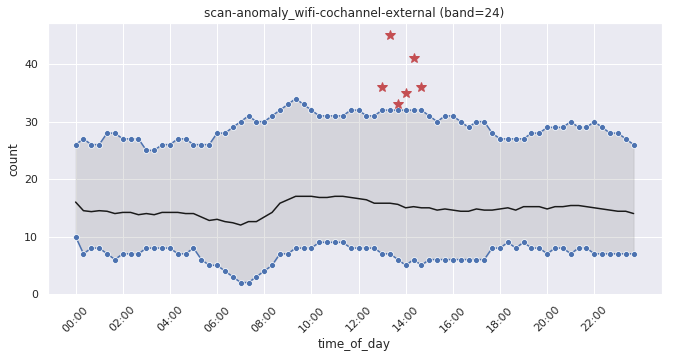

In [156]:
#cmd = 'scan-anomaly <> wifi-cochannel'
band='24'
idx_band = (model_all.band==band)
sns.set(rc={'figure.figsize':(11,5)})

for cmd in np.sort(model_all['command-reason'].unique()):
    idx = idx_band & (model_all['command-reason']==cmd)
    if sum(idx)>0:
        x_labels = model_all.loc[idx,'time_of_day'].values[::6]
        fig, ax = plt.subplots()
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='upper_limit', marker="o", color='b', ax=ax)
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='lower_limit', marker="o", color='b', ax=ax)
        _ = sns.lineplot(data=model_all[idx], x='time_of_day', y='median_count', color='k', ax=ax)
        #_ = sns.lineplot(data=model_all[idx], x='time_of_day', y='iqr_count', color='g', ax=ax)
        ax.fill_between(model_all.loc[idx,'time_of_day'],
                        model_all.loc[idx,'lower_limit'],
                        model_all.loc[idx,'upper_limit'],
                        alpha=0.2,
                        color='gray')
        
        test_idx = (df_test['band']==band)&(df_test['command-reason']==cmd)
        if sum(test_idx)>0:
            ax.plot(df_test.loc[test_idx,'time_of_day'], df_test.loc[test_idx,'rrm_local_cmd_count'], 'r*', ms=10)


        _ = ax.set_ylabel('count')
        _ = ax.set(xticks=x_labels,
                   title = f"{cmd} (band={band})")
        _ = ax.set_xticklabels(x_labels, rotation=45)

# Singular spectrum analysis

In [ ]:
################################
prefix = "s3://mist-aggregated-stats-production/aggregated-stats/rrm_local_cmd_count/"

#END_DATE = datetime.today()
END_DATE = datetime.strptime('2021-03-07', '%Y-%m-%d')
LAG = 28

dates = date_list(END_DATE, delta=LAG)
data_df = readParquet(prefix, dates)


data_df = data_df.withColumn("command-reason", F.concat(F.col("command").cast(StringType()),
                                                        F.lit("_"),
                                                        F.col("reason").cast(StringType()))).drop('reason')

data_df = data_df.withColumn("date", udf_roundDate(F.col("timestamp")))
feature_df = compose_features(data_df)

data_pandas = feature_df.toPandas()
################################

In [ ]:
df_pivot = data_pandas.pivot_table(index=['date','band'],
                                   columns='command-reason',

interval = [str(df_pivot.date.min().date())+' 05:30:00', str(df_pivot.date.max().date())+' 05:30:00']
idx = (df_pivot.date.between(*interval)) & (df_pivot.band=='5')
temp_resampled = df_pivot[idx].set_index('date').resample('20T').sum()

In [ ]:
var = 'capacity-anomaly_non-wifi'
plot_SSA(temp_resampled, var, max_rank=12, n_plot=12, zoom_level=3)